In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [19]:
import sys
sys.path.append("..")
import utils
import numpy as np

In [58]:
#all labels:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../data/pchembl_chemicals.csv')
targets = pd.read_csv('../data/subset_targets.csv')

In [12]:
probability_matrix = utils.train_label_correlation(interaction_matrix)

  0%|          | 262/85681 [00:00<00:32, 2619.48it/s]

y_in shape is: (337951, 243)


100%|██████████| 337951/337951 [00:51<00:00, 6577.15it/s]


In [26]:
probability_arr = probability_matrix.toarray()

In [27]:
arr = probability_matrix.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
0.99991256
Should be a low number >= 0:
0.0
Whole arr:


array([[328242,    138],
       [ 68104,    138],
       [315225,     72],
       ...,
       [132327,     26],
       [132327,     28],
       [337950,    242]])

In [65]:
##Test that it lines up:
for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)


C[C@@H](Oc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL601719 C[C@@H](Oc1cc(cnc1N)c2cnn(c2)C3CCNCC3)c4c(Cl)ccc(F)c4Cl
Nc1ncnc2sc... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1998585 Nc1ncnc2scc(c3ccc(NC(=O)Nc4cc(ccc4F)C(F)(F)F)cc3)c12
CCN(CC)CCN... Serine/threonine-protein kinase PIM1 	 Serine/threonine-protein kinase PIM1
CHEMBL535 CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C\2/C(=O)Nc3ccc(F)cc23)c1C
CNC(=O)c1c... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2005631 CNC(=O)c1cnc(N)c2c(csc12)c3ccc(NC(=O)Nc4cc(C)ccc4F)cc3
Cn1cc(cn1)... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL1988717 Cn1cc(cn1)c2cnn3c(N)c(cnc23)c4ccc(NC(=O)Nc5cccc(c5)C(F)(F)F)cc4
Cc1ccc(NC(... Vascular endothelial growth factor receptor 2 	 Vascular endothelial growth factor receptor 2
CHEMBL2000335 Cc1ccc

In [116]:
def clean_text(input_string):
    #source: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
    #replace these with whitespace:
    clean_string = re.sub(r"""
               [(),.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               input_string.lower(), flags=re.VERBOSE)
    
    #replace these with nothing:
    clean_string = clean_string.replace('-', '')
    clean_string = clean_string.replace('=', '')
    return clean_string


def get_synonyms(tid):
    target = new_client.target
    res = target.filter(target_chembl_id=tid)
    target_synonyms = [i['component_synonym'] for i in res[0]['target_components'][0]['target_component_synonyms']]
    #clean:
    target_synonyms = [clean_text(i) for i in target_synonyms]
    #make all lowercase to improve correct matchings:
    #target_synonyms = [i.lower() for i in target_synonyms]
    #remove all punctuations to improve correct matchings:
    #target_synonyms = [i.translate(str.maketrans('', '', string.punctuation)) for i in target_synonyms]
    
    return target_synonyms

def get_cid(smi):
    try:
        c = pcp.get_compounds(smi, 'smiles')[0]
        return c.cid
    except Exception as e:
        print(e)
        return None

def get_assay_summary(cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON').content)
    return b

def get_relevant_aids(assay_summary, synonyms):
    #iterates through all assays and checks for overlap in Assay Name with any of the synonyms. 
    #if there is a shared word, returns the pubchem assay ID. 
    #relevant_aids = list()
    bioactivity_outcomes = list()
    assay_names = list()
    
    for i in assay_summary['Table']['Row']:
        assay_name = i['Cell'][11]
        #trick from word embedding - remove all punctuations to improve word matching
        #assay_name = assay_name.translate(str.maketrans('', '', string.punctuation))
        clean_assay_name = clean_text(assay_name)
        #now match words:
        if len(set(synonyms).intersection(clean_assay_name.split()))>0:
            
            ###This is the variable that stores the 'active' or 'unspecified' or 'inactive' string:
            bioactivity_outcome = i['Cell'][6]
            ###
            
            bioactivity_outcomes.append(bioactivity_outcome)
            assay_names.append(assay_name)
            
            #this stores the AID number
            #relevant_aids.append(i['Cell'][0])

    return bioactivity_outcomes, assay_names#relevant_aids

def get_assay_details(aid, cid):
    b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'+str(aid)+'/JSON?cid='+str(cid)).content)
    return b

def get_pair_details(pair):
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    instance_id = smiles['instance_id'].iloc[pair[0]]
    predicted_target = targets['pref_name'].iloc[pair[1]]
    tid = targets[targets['pref_name']==predicted_target]['chembl_id'].iloc[0]
    return smi, instance_id, tid, predicted_target


In [174]:
def fetch_assay_details(tid, smi):
    if tid in synonym_dict:
        synonyms = synonym_dict[tid]
    else:
        synonyms = get_synonyms(tid)
        synonym_dict[tid] = synonyms

        
    if smi in cid_dict:
        compound_id = cid_dict[smi]
    else:
        compound_id = get_cid(smi)
        cid_dict[smi] = compound_id
        
    if compound_id in assay_dict:
        assay_summary = assay_dict[compound_id]
    else: 
        assay_summary = get_assay_summary(compound_id)
        assay_dict[compound_id]=assay_summary
        
    return synonyms, compound_id, assay_summary

In [175]:
# count = 0 
# synonym_dict = dict()
# cid_dict = dict()
# assay_dict = dict()
# assays_long = pd.DataFrame(columns=['ligandIdx', 'targetIdx', 'instance_id', 'pref_name', 'outcome', 'assayname'])
# rownum=0

# for count, pair in tqdm_notebook(enumerate(arr_sorted[:10000]), smoothing=0, total=10000):
#     print(f'testing {count}th pair: {pair} ... ', end=' ')
#     smi, instance_id, tid, pref_name = get_pair_details(pair)
    
#     synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
#     if 'Fault' in assay_summary.keys():
#         None
#         #print('No assays present.')
#     else:
#         bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
#         for outcome, aname in zip(bioactivity_outcomes, assay_names):
#             assays_long.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
#             rownum += 1
    
#     if count%100==0:
#         assays_long.to_csv('assays_long.csv')
#     print(' - finished.')

testing 0th pair: [328242    138] ...   - finished.
testing 1th pair: [68104   138] ...   - finished.
testing 2th pair: [315225     72] ...   - finished.
testing 3th pair: [68544   138] ...   - finished.
testing 4th pair: [67490   138] ...   - finished.
testing 5th pair: [68211   138] ...   - finished.
testing 6th pair: [68422    72] ...   - finished.
testing 7th pair: [68566    72] ...   - finished.
testing 8th pair: [325691     72] ...   - finished.
testing 9th pair: [12252    72] ...   - finished.
testing 10th pair: [66867   138] ...   - finished.
testing 11th pair: [66521   138] ...   - finished.
testing 12th pair: [106854    178] ...   - finished.
testing 13th pair: [275867    138] ...   - finished.
testing 14th pair: [135871    138] ...   - finished.
testing 15th pair: [65968   138] ...   - finished.
testing 16th pair: [68378   138] ...   - finished.
testing 17th pair: [123454    138] ...   - finished.
testing 18th pair: [67428    72] ...   - finished.
testing 19th pair: [337336 

testing 155th pair: [58250    72] ...   - finished.
testing 156th pair: [58242    72] ...   - finished.
testing 157th pair: [58246    72] ...   - finished.
testing 158th pair: [221103     72] ...   - finished.
testing 159th pair: [233777     72] ...   - finished.
testing 160th pair: [325135    138] ...   - finished.
testing 161th pair: [42629   149] ...   - finished.
testing 162th pair: [303829     72] ...   - finished.
testing 163th pair: [67124    72] ...   - finished.
testing 164th pair: [314179     72] ...   - finished.
testing 165th pair: [67124    79] ...   - finished.
testing 166th pair: [67382    72] ...   - finished.
testing 167th pair: [105358    166] ...   - finished.
testing 168th pair: [67124    36] ...   - finished.
testing 169th pair: [66162    79] ...   - finished.
testing 170th pair: [105359    166] ...   - finished.
testing 171th pair: [217403    166] ...   - finished.
testing 172th pair: [105362    166] ...   - finished.
testing 173th pair: [217659    166] ...   - fi

testing 309th pair: [292302    127] ...   - finished.
testing 310th pair: [321587    127] ...   - finished.
testing 311th pair: [163720    127] ...   - finished.
testing 312th pair: [322193    127] ...   - finished.
testing 313th pair: [84272   127] ...   - finished.
testing 314th pair: [132373    127] ...   - finished.
testing 315th pair: [67260   127] ...   - finished.
testing 316th pair: [132369    127] ...   - finished.
testing 317th pair: [323559    127] ...   - finished.
testing 318th pair: [270511    127] ...   - finished.
testing 319th pair: [150054    127] ...   - finished.
testing 320th pair: [292003    127] ...   - finished.
testing 321th pair: [150055    127] ...   - finished.
testing 322th pair: [150056    127] ...   - finished.
testing 323th pair: [322848    127] ...   - finished.
testing 324th pair: [150058    127] ...   - finished.
testing 325th pair: [150059    127] ...   - finished.
testing 326th pair: [217635    127] ...   - finished.
testing 327th pair: [82855   127

testing 462th pair: [227573    138] ...   - finished.
testing 463th pair: [269043    138] ...   - finished.
testing 464th pair: [239986    138] ...   - finished.
testing 465th pair: [250211    138] ...   - finished.
testing 466th pair: [234162    138] ...   - finished.
testing 467th pair: [281362    138] ...   - finished.
testing 468th pair: [265462    138] ...   - finished.
testing 469th pair: [278152    138] ...   - finished.
testing 470th pair: [276401    138] ...   - finished.
testing 471th pair: [232056    138] ...   - finished.
testing 472th pair: [283102    138] ...   - finished.
testing 473th pair: [267823    138] ...   - finished.
testing 474th pair: [209164    138] ...   - finished.
testing 475th pair: [256766    138] ...   - finished.
testing 476th pair: [209189    138] ...   - finished.
testing 477th pair: [278699    138] ...   - finished.
testing 478th pair: [283510    138] ...   - finished.
testing 479th pair: [258192    138] ...   - finished.
testing 480th pair: [264322 

testing 616th pair: [27603   177] ...   - finished.
testing 617th pair: [111479    177] ...   - finished.
testing 618th pair: [111478    177] ...   - finished.
testing 619th pair: [168340    177] ...   - finished.
testing 620th pair: [298713    177] ...   - finished.
testing 621th pair: [68841   177] ...   - finished.
testing 622th pair: [276711    177] ...   - finished.
testing 623th pair: [41142   177] ...   - finished.
testing 624th pair: [51535   177] ...   - finished.
testing 625th pair: [98630   177] ...   - finished.
testing 626th pair: [98631   177] ...   - finished.
testing 627th pair: [98632   177] ...   - finished.
testing 628th pair: [98633   177] ...   - finished.
testing 629th pair: [225291    177] ...   - finished.
testing 630th pair: [86349   177] ...   - finished.
testing 631th pair: [98634   177] ...   - finished.
testing 632th pair: [98635   177] ...   - finished.
testing 633th pair: [98639   177] ...   - finished.
testing 634th pair: [98640   177] ...   - finished.


testing 769th pair: [279567    166] ...   - finished.
testing 770th pair: [313145    166] ...   - finished.
testing 771th pair: [279662    166] ...   - finished.
testing 772th pair: [305254    166] ...   - finished.
testing 773th pair: [98588   166] ...   - finished.
testing 774th pair: [130865    166] ...   - finished.
testing 775th pair: [98590   166] ...   - finished.
testing 776th pair: [304724    166] ...   - finished.
testing 777th pair: [98591   166] ...   - finished.
testing 778th pair: [283374    166] ...   - finished.
testing 779th pair: [98593   166] ...   - finished.
testing 780th pair: [312694    166] ...   - finished.
testing 781th pair: [313401    166] ...   - finished.
testing 782th pair: [283170    166] ...   - finished.
testing 783th pair: [277132    166] ...   - finished.
testing 784th pair: [277698    166] ...   - finished.
testing 785th pair: [103944    166] ...   - finished.
testing 786th pair: [107500    166] ...   - finished.
testing 787th pair: [98594   166] ..

testing 923th pair: [131398     52] ...   - finished.
testing 924th pair: [133126     52] ...   - finished.
testing 925th pair: [153736     52] ...   - finished.
testing 926th pair: [107549     52] ...   - finished.
testing 927th pair: [156575     52] ...   - finished.
testing 928th pair: [216423     52] ...   - finished.
testing 929th pair: [292870     52] ...   - finished.
testing 930th pair: [86447    52] ...   - finished.
testing 931th pair: [160714     52] ...   - finished.
testing 932th pair: [156579     52] ...   - finished.
testing 933th pair: [13747    52] ...   - finished.
testing 934th pair: [321306     52] ...   - finished.
testing 935th pair: [153737     52] ...   - finished.
testing 936th pair: [153738     52] ...   - finished.
testing 937th pair: [147943     52] ...   - finished.
testing 938th pair: [133130     52] ...   - finished.
testing 939th pair: [153743     52] ...   - finished.
testing 940th pair: [153741     52] ...   - finished.
testing 941th pair: [131396     

testing 1074th pair: [155362     52] ...   - finished.
testing 1075th pair: [142973     52] ...   - finished.
testing 1076th pair: [217269     52] ...   - finished.
testing 1077th pair: [12296    52] ...   - finished.
testing 1078th pair: [321588     52] ...   - finished.
testing 1079th pair: [275683     52] ...   - finished.
testing 1080th pair: [322234     52] ...   - finished.
testing 1081th pair: [65228    52] ...   - finished.
testing 1082th pair: [65227    52] ...   - finished.
testing 1083th pair: [65223    52] ...   - finished.
testing 1084th pair: [65217    52] ...   - finished.
testing 1085th pair: [145266     52] ...   - finished.
testing 1086th pair: [145265     52] ...   - finished.
testing 1087th pair: [332133     52] ...   - finished.
testing 1088th pair: [226469     52] ...   - finished.
testing 1089th pair: [145264     52] ...   - finished.
testing 1090th pair: [164340     52] ...   - finished.
testing 1091th pair: [164342     52] ...   - finished.
testing 1092th pair:

testing 1225th pair: [148907     14] ...   - finished.
testing 1226th pair: [144574     14] ...   - finished.
testing 1227th pair: [148900     14] ...   - finished.
testing 1228th pair: [69492    14] ...   - finished.
testing 1229th pair: [217675     14] ...   - finished.
testing 1230th pair: [273309     14] ...   - finished.
testing 1231th pair: [280055     14] ...   - finished.
testing 1232th pair: [108590     14] ...   - finished.
testing 1233th pair: [68187   142] ...   - finished.
testing 1234th pair: [127696     90] ...   - finished.
testing 1235th pair: [88968   142] ...   - finished.
testing 1236th pair: [67089   224] ...   - finished.
testing 1237th pair: [164181     90] ...   - finished.
testing 1238th pair: [66308    79] ...   - finished.
testing 1239th pair: [66712    73] ...   - finished.
testing 1240th pair: [67070   142] ...   - finished.
testing 1241th pair: [68108   178] ...   - finished.
testing 1242th pair: [135536     76] ...   - finished.
testing 1243th pair: [3373

testing 1377th pair: [276042     90] ...   - finished.
testing 1378th pair: [8195   90] ...   - finished.
testing 1379th pair: [164260     90] ...   - finished.
testing 1380th pair: [164261     90] ...   - finished.
testing 1381th pair: [126986     90] ...   - finished.
testing 1382th pair: [67091    90] ...   - finished.
testing 1383th pair: [8064   90] ...   - finished.
testing 1384th pair: [97859    90] ...   - finished.
testing 1385th pair: [97858    90] ...   - finished.
testing 1386th pair: [97856    90] ...   - finished.
testing 1387th pair: [51214    90] ...   - finished.
testing 1388th pair: [75140    90] ...   - finished.
testing 1389th pair: [37844    90] ...   - finished.
testing 1390th pair: [323920     90] ...   - finished.
testing 1391th pair: [306272     90] ...   - finished.
testing 1392th pair: [63775    90] ...   - finished.
testing 1393th pair: [299307     90] ...   - finished.
testing 1394th pair: [159360     90] ...   - finished.
testing 1395th pair: [323890     9

testing 1528th pair: [105149     72] ...   - finished.
testing 1529th pair: [68501   142] ...   - finished.
testing 1530th pair: [194501    138] ...   - finished.
testing 1531th pair: [268603    138] ...   - finished.
testing 1532th pair: [194563    138] ...   - finished.
testing 1533th pair: [194574    138] ...   - finished.
testing 1534th pair: [279726    138] ...   - finished.
testing 1535th pair: [194497    138] ...   - finished.
testing 1536th pair: [260112    138] ...   - finished.
testing 1537th pair: [194496    138] ...   - finished.
testing 1538th pair: [194540    138] ...   - finished.
testing 1539th pair: [270308    138] ...   - finished.
testing 1540th pair: [194500    138] ...   - finished.
testing 1541th pair: [194513    138] ...   - finished.
testing 1542th pair: [194507    138] ...   - finished.
testing 1543th pair: [194575    138] ...   - finished.
testing 1544th pair: [167392    138] ...   - finished.
testing 1545th pair: [194510    138] ...   - finished.
testing 1546

testing 1677th pair: [67017    72] ...   - finished.
testing 1678th pair: [289016     72] ...   - finished.
testing 1679th pair: [299639     72] ...   - finished.
testing 1680th pair: [308381     72] ...   - finished.
testing 1681th pair: [309176     72] ...   - finished.
testing 1682th pair: [308145     72] ...   - finished.
testing 1683th pair: [308144     72] ...   - finished.
testing 1684th pair: [221383     72] ...   - finished.
testing 1685th pair: [308197     72] ...   - finished.
testing 1686th pair: [308138     72] ...   - finished.
testing 1687th pair: [202345     72] ...   - finished.
testing 1688th pair: [246242     72] ...   - finished.
testing 1689th pair: [75036    72] ...   - finished.
testing 1690th pair: [130039     72] ...   - finished.
testing 1691th pair: [202321     72] ...   - finished.
testing 1692th pair: [307893     72] ...   - finished.
testing 1693th pair: [202320     72] ...   - finished.
testing 1694th pair: [307849     72] ...   - finished.
testing 1695th

testing 1916th pair: [277245    127] ...   - finished.
testing 1917th pair: [217466    127] ...   - finished.
testing 1918th pair: [65229   127] ...   - finished.
testing 1919th pair: [275227    127] ...   - finished.
testing 1920th pair: [223464    127] ...   - finished.
testing 1921th pair: [23701   127] ...   - finished.
testing 1922th pair: [160717    127] ...   - finished.
testing 1923th pair: [333597    127] ...   - finished.
testing 1924th pair: [149259    127] ...   - finished.
testing 1925th pair: [321306    127] ...   - finished.
testing 1926th pair: [153291    127] ...   - finished.
testing 1927th pair: [223555    127] ...   - finished.
testing 1928th pair: [149256    127] ...   - finished.
testing 1929th pair: [98983   127] ...   - finished.
testing 1930th pair: [322234    127] ...   - finished.
testing 1931th pair: [149255    127] ...   - finished.
testing 1932th pair: [96023   127] ...   - finished.
testing 1933th pair: [65230   127] ...   - finished.
testing 1934th pair:

testing 2067th pair: [171134    149] ...   - finished.
testing 2068th pair: [171135    149] ...   - finished.
testing 2069th pair: [242603    149] ...   - finished.
testing 2070th pair: [188499    149] ...   - finished.
testing 2071th pair: [188501    149] ...   - finished.
testing 2072th pair: [232385    149] ...   - finished.
testing 2073th pair: [171136    149] ...   - finished.
testing 2074th pair: [171142    149] ...   - finished.
testing 2075th pair: [188461    149] ...   - finished.
testing 2076th pair: [263102    149] ...   - finished.
testing 2077th pair: [216034    149] ...   - finished.
testing 2078th pair: [171137    149] ...   - finished.
testing 2079th pair: [188500    149] ...   - finished.
testing 2080th pair: [255120    149] ...   - finished.
testing 2081th pair: [171140    149] ...   - finished.
testing 2082th pair: [277781    149] ...   - finished.
testing 2083th pair: [235055    149] ...   - finished.
testing 2084th pair: [266089    149] ...   - finished.
testing 20

testing 2216th pair: [188481    149] ...   - finished.
testing 2217th pair: [185603    149] ...   - finished.
testing 2218th pair: [188480    149] ...   - finished.
testing 2219th pair: [230654    149] ...   - finished.
testing 2220th pair: [188479    149] ...   - finished.
testing 2221th pair: [227679    149] ...   - finished.
testing 2222th pair: [238367    149] ...   - finished.
testing 2223th pair: [188487    149] ...   - finished.
testing 2224th pair: [235686    149] ...   - finished.
testing 2225th pair: [281355    149] ...   - finished.
testing 2226th pair: [245172    149] ...   - finished.
testing 2227th pair: [185098    149] ...   - finished.
testing 2228th pair: [185099    149] ...   - finished.
testing 2229th pair: [185100    149] ...   - finished.
testing 2230th pair: [185101    149] ...   - finished.
testing 2231th pair: [185102    149] ...   - finished.
testing 2232th pair: [188486    149] ...   - finished.
testing 2233th pair: [185103    149] ...   - finished.
testing 22

testing 2366th pair: [107459    127] ...   - finished.
testing 2367th pair: [107452    127] ...   - finished.
testing 2368th pair: [107456    127] ...   - finished.
testing 2369th pair: [158994    127] ...   - finished.
testing 2370th pair: [51703   127] ...   - finished.
testing 2371th pair: [226923    127] ...   - finished.
testing 2372th pair: [159012    127] ...   - finished.
testing 2373th pair: [107451    127] ...   - finished.
testing 2374th pair: [57878   138] ...   - finished.
testing 2375th pair: [66712    79] ...   - finished.
testing 2376th pair: [295905     95] ...   - finished.
testing 2377th pair: [312537     95] ...   - finished.
testing 2378th pair: [31291   127] ...   - finished.
testing 2379th pair: [66229   224] ...   - finished.
testing 2380th pair: [300346    164] ...   - finished.
testing 2381th pair: [68215   215] ...   - finished.
testing 2382th pair: [110845    127] ...   - finished.
testing 2383th pair: [67454   205] ...   - finished.
testing 2384th pair: [66

testing 2517th pair: [132697    127] ...   - finished.
testing 2518th pair: [337435     76] ...   - finished.
testing 2519th pair: [16009   194] ...   - finished.
testing 2520th pair: [30895   177] ...   - finished.
testing 2521th pair: [139467    177] ...   - finished.
testing 2522th pair: [139469    177] ...   - finished.
testing 2523th pair: [130082     86] ...   - finished.
testing 2524th pair: [315397    177] ...   - finished.
testing 2525th pair: [66920   128] ...   - finished.
testing 2526th pair: [165897    177] ...   - finished.
testing 2527th pair: [165898    177] ...   - finished.
testing 2528th pair: [226197    177] ...   - finished.
testing 2529th pair: [300012    177] ...   - finished.
testing 2530th pair: [293385    177] ...   - finished.
testing 2531th pair: [139470    177] ...   - finished.
testing 2532th pair: [139466    177] ...   - finished.
testing 2533th pair: [9340  177] ...   - finished.
testing 2534th pair: [55508   177] ...   - finished.
testing 2535th pair: [

KeyboardInterrupt: 

In [183]:
rownum

1052

In [ ]:
#stuck on the 2594th pair....
##starting again from 2595 with a sigkill for too long time.

import time as time
import signal
#Close session
def handler(signum, frame):
    raise Exception('Action took too much time')
signal.signal(signal.SIGALRM, handler)
signal.alarm(15) #Set the parameter to the amount of seconds you want to wait
    
for count, pair in tqdm_notebook(enumerate(arr_sorted[2595:10000]), smoothing=0, total=10000):
    print(f'testing {count}th pair: {pair} ... ', end=' ')
    try:
        smi, instance_id, tid, pref_name = get_pair_details(pair)
    
        synonyms, compound_id, assay_summary = fetch_assay_details(tid, smi )
    
    
        if 'Fault' in assay_summary.keys():
            None
            #print('No assays present.')
        else:
            bioactivity_outcomes, assay_names = get_relevant_aids(assay_summary, synonyms)
            for outcome, aname in zip(bioactivity_outcomes, assay_names):
                assays_long.loc[rownum]=[pair[0], pair[1], instance_id, pref_name, outcome, aname]
                rownum += 1
    
        if count%100==0:
            assays_long.to_csv('assays_long.csv')
        print(' - finished.')
    except (KeyboardInterrupt, Exception):
        print('took too long. moving on.')
        

testing 0th pair: [14445    76] ...   - finished.
testing 1th pair: [14457    76] ...   - finished.
testing 2th pair: [14489    76] ...   - finished.
testing 3th pair: [14300    76] ...   - finished.
testing 4th pair: [14491    76] ...  Action took too much time
 - finished.
testing 5th pair: [14490    76] ...  took too long. moving on.
testing 6th pair: [14288    76] ...   - finished.
testing 7th pair: [14285    76] ...   - finished.
testing 8th pair: [336937     76] ...  took too long. moving on.
testing 9th pair: [330068     76] ...   - finished.
testing 10th pair: [9170   83] ...  took too long. moving on.
testing 11th pair: [68068   215] ...   - finished.
testing 12th pair: [236194     84] ...  took too long. moving on.
testing 13th pair: [153449    194] ...  took too long. moving on.
testing 14th pair: [16124   194] ...  took too long. moving on.
testing 15th pair: [300346     73] ...   - finished.
testing 16th pair: [89779   178] ...  took too long. moving on.
testing 17th pair:

testing 149th pair: [90247    52] ...   - finished.
testing 150th pair: [105377     52] ...   - finished.
testing 151th pair: [105376     52] ...  took too long. moving on.
testing 152th pair: [101473     52] ...   - finished.
testing 153th pair: [37959    52] ...   - finished.
testing 154th pair: [37958    52] ...   - finished.
testing 155th pair: [37957    52] ...   - finished.
testing 156th pair: [296920     52] ...   - finished.
testing 157th pair: [55968    52] ...   - finished.
testing 158th pair: [278122     52] ...   - finished.
testing 159th pair: [300371     52] ...   - finished.
testing 160th pair: [211915     52] ...   - finished.
testing 161th pair: [77908    52] ...   - finished.
testing 162th pair: [130842     52] ...   - finished.
testing 163th pair: [100307     52] ...   - finished.
testing 164th pair: [100306     52] ...   - finished.
testing 165th pair: [130841     52] ...   - finished.
testing 166th pair: [130840     52] ...   - finished.
testing 167th pair: [274768

testing 303th pair: [307572    224] ...   - finished.
testing 304th pair: [227919     76] ...   - finished.
testing 305th pair: [89910    83] ...   - finished.
testing 306th pair: [322560    149] ...   - finished.
testing 307th pair: [67018    73] ...   - finished.
testing 308th pair: [66867    79] ...   - finished.
testing 309th pair: [68038   123] ...   - finished.
testing 310th pair: [210167    138] ...   - finished.
testing 311th pair: [135871    224] ...   - finished.
testing 312th pair: [66685   215] ...   - finished.
testing 313th pair: [15417   128] ...   - finished.
testing 314th pair: [221090    138] ...   - finished.
testing 315th pair: [66507   215] ...   - finished.
testing 316th pair: [315 224] ...   - finished.
testing 317th pair: [294024     83] ...   - finished.
testing 318th pair: [68560   205] ...   - finished.
testing 319th pair: [303613     36] ...   - finished.
testing 320th pair: [66128   205] ...   - finished.
testing 321th pair: [336359    170] ...   - finished

testing 457th pair: [63140   134] ...   - finished.
testing 458th pair: [246848    134] ...   - finished.
testing 459th pair: [68781   134] ...   - finished.
testing 460th pair: [62906   134] ...   - finished.
testing 461th pair: [160363    134] ...   - finished.
testing 462th pair: [94927   134] ...   - finished.
testing 463th pair: [94921   134] ...   - finished.
testing 464th pair: [27993   134] ...   - finished.
testing 465th pair: [117023    134] ...   - finished.
testing 466th pair: [68937   134] ...   - finished.
testing 467th pair: [33330   134] ...   - finished.
testing 468th pair: [221391    134] ...   - finished.
testing 469th pair: [232037    134] ...   - finished.
testing 470th pair: [68938   134] ...   - finished.
testing 471th pair: [68929   134] ...   - finished.
testing 472th pair: [68920   134] ...   - finished.
testing 473th pair: [68924   134] ...   - finished.
testing 474th pair: [68928   134] ...   - finished.
testing 475th pair: [69012   134] ...   - finished.
te

testing 612th pair: [81571   116] ...   - finished.
testing 613th pair: [81538   116] ...   - finished.
testing 614th pair: [226895    116] ...   - finished.
testing 615th pair: [93085   116] ...   - finished.
testing 616th pair: [93084   116] ...   - finished.
testing 617th pair: [118070    116] ...   - finished.
testing 618th pair: [133525    116] ...   - finished.
testing 619th pair: [133524    116] ...   - finished.
testing 620th pair: [133523    116] ...   - finished.
testing 621th pair: [133522    116] ...   - finished.
testing 622th pair: [273991    116] ...   - finished.
testing 623th pair: [296562    116] ...   - finished.
testing 624th pair: [7592  116] ...   - finished.
testing 625th pair: [79000   116] ...   - finished.
testing 626th pair: [278118    116] ...   - finished.
testing 627th pair: [78918   116] ...   - finished.
testing 628th pair: [272647    116] ...   - finished.
testing 629th pair: [314938    116] ...   - finished.
testing 630th pair: [272676    116] ...   - 

testing 766th pair: [239633     94] ...   - finished.
testing 767th pair: [331767     94] ...   - finished.
testing 768th pair: [88966    94] ...   - finished.
testing 769th pair: [126159     94] ...   - finished.
testing 770th pair: [43398    94] ...   - finished.
testing 771th pair: [126208     94] ...   - finished.
testing 772th pair: [249923     94] ...   - finished.
testing 773th pair: [295297     94] ...   - finished.
testing 774th pair: [126157     94] ...   - finished.
testing 775th pair: [331595     94] ...   - finished.
testing 776th pair: [292584     94] ...   - finished.
testing 777th pair: [126027     94] ...   - finished.
testing 778th pair: [223472     94] ...   - finished.
testing 779th pair: [128096     94] ...   - finished.
testing 780th pair: [42339    94] ...   - finished.
testing 781th pair: [9839   94] ...   - finished.
testing 782th pair: [333893     94] ...   - finished.
testing 783th pair: [275274     94] ...   - finished.
testing 784th pair: [331619     94] ..

testing 920th pair: [38622   149] ...   - finished.
testing 921th pair: [66629   215] ...   - finished.
testing 922th pair: [67383   154] ...   - finished.
testing 923th pair: [326054    138] ...   - finished.
testing 924th pair: [328855    138] ...   - finished.
testing 925th pair: [68046   138] ...   - finished.
testing 926th pair: [68468   215] ...   - finished.
testing 927th pair: [312432     83] ...   - finished.
testing 928th pair: [67514   150] ...   - finished.
testing 929th pair: [68213   150] ...   - finished.
testing 930th pair: [160360    199] ...   - finished.
testing 931th pair: [160361    199] ...   - finished.
testing 932th pair: [160346    199] ...   - finished.
testing 933th pair: [67584   215] ...   - finished.
testing 934th pair: [68070   138] ...   - finished.
testing 935th pair: [55118   178] ...   - finished.
testing 936th pair: [15836   215] ...   - finished.
testing 937th pair: [67659   178] ...   - finished.
testing 938th pair: [325135    214] ...   - finished

testing 1073th pair: [293647     98] ...   - finished.
testing 1074th pair: [82093    98] ...   - finished.
testing 1075th pair: [220650     98] ...   - finished.
testing 1076th pair: [81733    98] ...   - finished.
testing 1077th pair: [81937    98] ...   - finished.
testing 1078th pair: [81962    98] ...   - finished.
testing 1079th pair: [81901    98] ...   - finished.
testing 1080th pair: [332779     76] ...   - finished.
testing 1081th pair: [67265   215] ...   - finished.
testing 1082th pair: [68059    36] ...   - finished.
testing 1083th pair: [336075    205] ...   - finished.
testing 1084th pair: [212254    154] ...   - finished.
testing 1085th pair: [68514   215] ...   - finished.
testing 1086th pair: [67529   215] ...   - finished.
testing 1087th pair: [66130   138] ...   - finished.
testing 1088th pair: [298891    164] ...   - finished.
testing 1089th pair: [67452   150] ...   - finished.
testing 1090th pair: [224180     76] ...   - finished.
testing 1091th pair: [67706   14

testing 1225th pair: [45494   169] ...   - finished.
testing 1226th pair: [322533    169] ...   - finished.
testing 1227th pair: [4399  169] ...   - finished.
testing 1228th pair: [244336    169] ...   - finished.
testing 1229th pair: [62032   169] ...   - finished.
testing 1230th pair: [317030    169] ...   - finished.
testing 1231th pair: [45791   169] ...   - finished.
testing 1232th pair: [45793   169] ...   - finished.
testing 1233th pair: [257917    169] ...   - finished.
testing 1234th pair: [45790   169] ...   - finished.
testing 1235th pair: [319380    169] ...   - finished.
testing 1236th pair: [49783   169] ...   - finished.
testing 1237th pair: [45789   169] ...   - finished.
testing 1238th pair: [49782   169] ...   - finished.
testing 1239th pair: [45788   169] ...   - finished.
testing 1240th pair: [49781   169] ...   - finished.
testing 1241th pair: [190820    169] ...   - finished.
testing 1242th pair: [45786   169] ...   - finished.
testing 1243th pair: [49767   169] .

testing 1377th pair: [109200    142] ...   - finished.
testing 1378th pair: [277755    142] ...   - finished.
testing 1379th pair: [283016    142] ...   - finished.
testing 1380th pair: [280777    142] ...   - finished.
testing 1381th pair: [279924    142] ...   - finished.
testing 1382th pair: [276666    142] ...   - finished.
testing 1383th pair: [276737    142] ...   - finished.
testing 1384th pair: [109203    142] ...   - finished.
testing 1385th pair: [109202    142] ...   - finished.
testing 1386th pair: [282468    142] ...   - finished.
testing 1387th pair: [109197    142] ...   - finished.
testing 1388th pair: [165343    142] ...   - finished.
testing 1389th pair: [277571    142] ...   - finished.
testing 1390th pair: [68215    11] ...   - finished.
testing 1391th pair: [22247    84] ...   - finished.
testing 1392th pair: [154201     76] ...   - finished.
testing 1393th pair: [68420   215] ...   - finished.
testing 1394th pair: [67909   215] ...   - finished.
testing 1395th pai

testing 1528th pair: [106258    215] ...   - finished.
testing 1529th pair: [319592    215] ...   - finished.
testing 1530th pair: [78790   215] ...   - finished.
testing 1531th pair: [166180    215] ...   - finished.
testing 1532th pair: [233461    215] ...   - finished.
testing 1533th pair: [267719    215] ...   - finished.
testing 1534th pair: [269788    215] ...   - finished.
testing 1535th pair: [64133   215] ...   - finished.
testing 1536th pair: [106264    215] ...   - finished.
testing 1537th pair: [57933   215] ...   - finished.
testing 1538th pair: [260581    215] ...   - finished.
testing 1539th pair: [251742    215] ...   - finished.
testing 1540th pair: [278585    215] ...   - finished.
testing 1541th pair: [64080   215] ...   - finished.
testing 1542th pair: [106262    215] ...   - finished.
testing 1543th pair: [67100   215] ...   - finished.
testing 1544th pair: [16236   215] ...   - finished.
testing 1545th pair: [16237   215] ...   - finished.
testing 1546th pair: [28

testing 1679th pair: [325830     83] ...   - finished.
testing 1680th pair: [295295     83] ...   - finished.
testing 1681th pair: [323904     83] ...   - finished.
testing 1682th pair: [124344     83] ...   - finished.
testing 1683th pair: [293746     83] ...   - finished.
testing 1684th pair: [329041     83] ...   - finished.
testing 1685th pair: [325529     83] ...   - finished.
testing 1686th pair: [157500     91] ...   - finished.
testing 1687th pair: [320784     14] ...   - finished.
testing 1688th pair: [276100     14] ...   - finished.
testing 1689th pair: [321566     14] ...   - finished.
testing 1690th pair: [278463     14] ...   - finished.
testing 1691th pair: [321777     14] ...   - finished.
testing 1692th pair: [321526     14] ...   - finished.
testing 1693th pair: [166277    165] ...   - finished.
testing 1694th pair: [223453    165] ...   - finished.
testing 1695th pair: [302999    165] ...   - finished.
testing 1696th pair: [301980    165] ...   - finished.
testing 16

testing 1830th pair: [75064   165] ...   - finished.
testing 1831th pair: [75072   165] ...   - finished.
testing 1832th pair: [75074   165] ...   - finished.
testing 1833th pair: [75075   165] ...   - finished.
testing 1834th pair: [75076   165] ...   - finished.
testing 1835th pair: [75077   165] ...   - finished.
testing 1836th pair: [75078   165] ...   - finished.
testing 1837th pair: [126879    165] ...   - finished.
testing 1838th pair: [56921   165] ...   - finished.
testing 1839th pair: [126863    165] ...   - finished.
testing 1840th pair: [331647    165] ...   - finished.
testing 1841th pair: [276887    165] ...   - finished.
testing 1842th pair: [75073   165] ...   - finished.
testing 1843th pair: [277134    165] ...   - finished.
testing 1844th pair: [316557    165] ...   - finished.
testing 1845th pair: [52690   165] ...   - finished.
testing 1846th pair: [18243   165] ...   - finished.
testing 1847th pair: [212324    165] ...   - finished.
testing 1848th pair: [185775    

testing 1981th pair: [282276    165] ...   - finished.
testing 1982th pair: [296063    165] ...   - finished.
testing 1983th pair: [53456   165] ...   - finished.
testing 1984th pair: [65731   165] ...   - finished.
testing 1985th pair: [164447    165] ...   - finished.
testing 1986th pair: [167976    165] ...   - finished.
testing 1987th pair: [58968   165] ...   - finished.
testing 1988th pair: [65730   165] ...   - finished.
testing 1989th pair: [296057    165] ...   - finished.
testing 1990th pair: [50119   165] ...   - finished.
testing 1991th pair: [283767    165] ...   - finished.
testing 1992th pair: [280993    165] ...   - finished.
testing 1993th pair: [296107    165] ...   - finished.
testing 1994th pair: [283758    165] ...   - finished.
testing 1995th pair: [166604    165] ...   - finished.
testing 1996th pair: [281520    165] ...   - finished.
testing 1997th pair: [226625    165] ...   - finished.
testing 1998th pair: [105723    165] ...   - finished.
testing 1999th pair:

testing 2132th pair: [60702   165] ...   - finished.
testing 2133th pair: [60703   165] ...   - finished.
testing 2134th pair: [18662   165] ...   - finished.
testing 2135th pair: [60704   165] ...   - finished.
testing 2136th pair: [60710   165] ...   - finished.
testing 2137th pair: [107987    165] ...   - finished.
testing 2138th pair: [278953    165] ...   - finished.
testing 2139th pair: [107317    165] ...   - finished.
testing 2140th pair: [284088    165] ...   - finished.
testing 2141th pair: [60705   165] ...   - finished.
testing 2142th pair: [278945    165] ...   - finished.
testing 2143th pair: [60706   165] ...   - finished.
testing 2144th pair: [18661   165] ...   - finished.
testing 2145th pair: [60707   165] ...   - finished.
testing 2146th pair: [195127    165] ...   - finished.
testing 2147th pair: [18432   165] ...   - finished.
testing 2148th pair: [60708   165] ...   - finished.
testing 2149th pair: [60709   165] ...   - finished.
testing 2150th pair: [51469   165]

testing 2283th pair: [29881    76] ...   - finished.
testing 2284th pair: [68010   131] ...   - finished.
testing 2285th pair: [91014    86] ...   - finished.
testing 2286th pair: [300218     71] ...   - finished.
testing 2287th pair: [57917    91] ...   - finished.
testing 2288th pair: [305078     38] ...   - finished.
testing 2289th pair: [231370     83] ...   - finished.
testing 2290th pair: [242293     83] ...   - finished.
testing 2291th pair: [82462    83] ...   - finished.
testing 2292th pair: [82474    83] ...   - finished.
testing 2293th pair: [82473    83] ...   - finished.
testing 2294th pair: [229006     83] ...   - finished.
testing 2295th pair: [45404    83] ...   - finished.
testing 2296th pair: [82472    83] ...   - finished.
testing 2297th pair: [240223     83] ...   - finished.
testing 2298th pair: [82471    83] ...   - finished.
testing 2299th pair: [82463    83] ...   - finished.
testing 2300th pair: [82422    83] ...   - finished.
testing 2301th pair: [82470    83]

testing 2434th pair: [45424    83] ...   - finished.
testing 2435th pair: [45426    83] ...   - finished.
testing 2436th pair: [325135    142] ...   - finished.
testing 2437th pair: [45408    83] ...   - finished.
testing 2438th pair: [45422    83] ...   - finished.
testing 2439th pair: [45421    83] ...   - finished.
testing 2440th pair: [45409    83] ...   - finished.
testing 2441th pair: [45425    83] ...   - finished.
testing 2442th pair: [45413    83] ...   - finished.
testing 2443th pair: [45402    83] ...   - finished.
testing 2444th pair: [45420    83] ...   - finished.
testing 2445th pair: [45416    83] ...   - finished.
testing 2446th pair: [45419    83] ...   - finished.
testing 2447th pair: [66880   128] ...   - finished.
testing 2448th pair: [67141   150] ...   - finished.
testing 2449th pair: [16187    98] ...   - finished.
testing 2450th pair: [298086     91] ...   - finished.
testing 2451th pair: [138404     83] ...   - finished.
testing 2452th pair: [334281     91] ...

testing 2585th pair: [167331    162] ...   - finished.
testing 2586th pair: [187835    162] ...   - finished.
testing 2587th pair: [187843    162] ...   - finished.
testing 2588th pair: [190799    162] ...   - finished.
testing 2589th pair: [3589  162] ...   - finished.
testing 2590th pair: [63175   162] ...   - finished.
testing 2591th pair: [187833    162] ...   - finished.
testing 2592th pair: [276038    162] ...   - finished.
testing 2593th pair: [190796    162] ...   - finished.
testing 2594th pair: [190794    162] ...   - finished.
testing 2595th pair: [187832    162] ...   - finished.
testing 2596th pair: [67083   162] ...   - finished.
testing 2597th pair: [190802    162] ...   - finished.
testing 2598th pair: [294342    162] ...   - finished.
testing 2599th pair: [255908     91] ...   - finished.
testing 2600th pair: [67859   164] ...   - finished.
testing 2601th pair: [315082     91] ...   - finished.
testing 2602th pair: [68534   224] ...   - finished.
testing 2603th pair: [

testing 2736th pair: [110864    177] ...   - finished.
testing 2737th pair: [142971    177] ...   - finished.
testing 2738th pair: [145273    177] ...   - finished.
testing 2739th pair: [98986   177] ...   - finished.
testing 2740th pair: [243767    177] ...   - finished.
testing 2741th pair: [142972    177] ...   - finished.
testing 2742th pair: [28531   177] ...   - finished.
testing 2743th pair: [250925    177] ...   - finished.
testing 2744th pair: [335655    177] ...   - finished.
testing 2745th pair: [161484    177] ...   - finished.
testing 2746th pair: [128864    177] ...   - finished.
testing 2747th pair: [215218    177] ...   - finished.
testing 2748th pair: [215358    177] ...   - finished.
testing 2749th pair: [300181    177] ...   - finished.
testing 2750th pair: [283925    177] ...   - finished.
testing 2751th pair: [67910   224] ...   - finished.
testing 2752th pair: [53416   128] ...   - finished.
testing 2753th pair: [66439   150] ...   - finished.
testing 2754th pair:

testing 2888th pair: [115003     76] ...   - finished.
testing 2889th pair: [67372   180] ...   - finished.
testing 2890th pair: [68158   150] ...   - finished.
testing 2891th pair: [273226     91] ...   - finished.
testing 2892th pair: [25205    91] ...   - finished.
testing 2893th pair: [42838    91] ...   - finished.
testing 2894th pair: [67538    73] ...   - finished.
testing 2895th pair: [224389     84] ...   - finished.
testing 2896th pair: [224520     84] ...   - finished.
testing 2897th pair: [66920    72] ...   - finished.
testing 2898th pair: [68187   123] ...   - finished.
testing 2899th pair: [57914    91] ...   - finished.
testing 2900th pair: [68051   154] ...   - finished.
testing 2901th pair: [66361    36] ...   - finished.
testing 2902th pair: [67770   224] ...   - finished.
testing 2903th pair: [94839   138] ...   - finished.
testing 2904th pair: [330665     90] ...   - finished.
testing 2905th pair: [292540    103] ...   - finished.
testing 2906th pair: [122416     8

In [68]:
both = 0
neg = 0
pos = 0
positive_targs = list()
both_targs = list()
negative_targs= list()

for count, item in enumerate(assay_keeper):
    active = 'Active' in item['Outcome'].tolist()
    inactive = 'Inactive' in item['Outcome'].tolist()
    
    if active and inactive:
        both += 1
        both_targs.append(count)
    elif active:
        pos += 1
        positive_targs.append(count)
    elif inactive:
        neg += 1
        negative_targs.append(count)

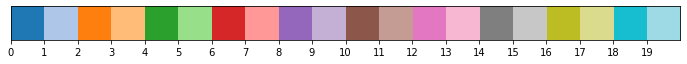

In [70]:
##Use this to choose colours for the horizontal barplots
from matplotlib import colors

def view_colormap(cmap):
    """Plot a colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    
    fig, ax = plt.subplots(1, figsize=(12, 3),
                           subplot_kw=dict(xticks=range(len(colors)), yticks=[]))
    ax.imshow([colors], extent=[0, len(colors), 0, 1])

    
view_colormap('tab20')

In [71]:
def makeCmap(name, color_nums):
    cmap = plt.get_cmap(name)
    cmap2 = colors.ListedColormap([cmap.colors[i] for i in color_nums])
    #bounds=[i for i in range(len(color_nums))]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    
    return cmap2#, norm

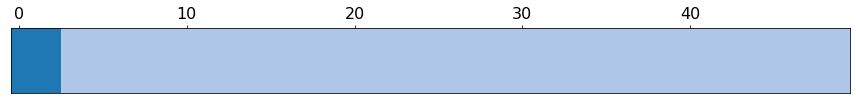

In [72]:
cmap = makeCmap('tab20', [0, 1])


arr = np.zeros([50,1])
arr[0:both+pos+neg] = 0
arr[both+pos+neg:] = 1

#cmap = plt.get_cmap('tab20')
#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
ax.xaxis.tick_top()
ax.set_yticks([])

ax.tick_params(axis="x", labelsize=16)
ax.imshow(arr.T, cmap=cmap, aspect='auto')
plt.tight_layout()
#fig.savefig('total_assays.png')

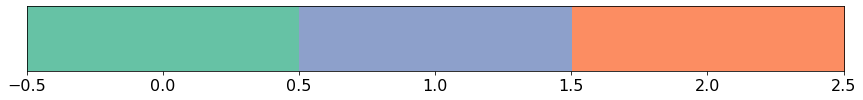

In [73]:
#Use this when you have active, inactive, and ambiguous evidence
#cmap = makeCmap('Set2', [1,2,0])

#Use this for the demo, where we only have active evidence (the 
#order gets messed up when there's only one type of result)
cmap = makeCmap('Set2', [0,2,1])


arr = np.zeros([pos+both+neg,1])
arr[0:neg] = 0
arr[neg:neg+both] = 1
arr[neg+both:] = 2


#cmap = plt.cm.get_cmap('Blues', 2)
fig, ax = plt.subplots(1)
fig.set_figheight(1.5)
fig.set_figwidth(12)
#ax.xaxis.tick_top()
ax.set_yticks([])
ax.tick_params(axis="x", labelsize=16)
plt.tight_layout()
ax.imshow(arr.T, cmap=cmap, aspect='auto')

#fig.savefig('assay_results.png')

In [76]:
targs = list()

for count, pair in enumerate(arr_sorted[:10000]):
    predicted_target = targets['pref_name'].iloc[pair[1]]
    targs.append(predicted_target)
    
pdf = pd.DataFrame(targs)

a= pdf.iloc[positive_targs][0].value_counts()

In [83]:
#Print out percentages of ambiguous evidence, negative evidence, and positive evidence
tot = both+pos+neg
print('Num negative assays:', neg)
print(neg/tot*100)

print('Num with ambiguous assay evidence:', both)
print(both/tot*100)

print('Num with positive assay evidence:', pos)
print(pos/tot*(100))


Num negative assays: 1
33.33333333333333
Num with ambiguous assay evidence: 1
33.33333333333333
Num with positive assay evidence: 1
33.33333333333333
